
# Final Red Sea GPS Jamming Detection — Part A  
**Author:** Ashim Sharma (on behalf of candidate)  
**Role:** Senior Data Analyst  
**Objective Date:** Nov 2025  

## 1. Business Context & Objective

The Red Sea is a geopolitically sensitive and high‑risk maritime corridor. Vessels transiting this region are increasingly affected by **GPS jamming/spoofing**, which can create *false vessel meetings* on AIS/GPS records — fake rendezvous that never physically occurred.

**Business Problem**  
Identify and label suspicious "meetings" between vessels where reported locations, timings, and movements are **not physically plausible**, and are likely artifacts of GPS interference. These anomalies are critical because they can:

- Obscure real ship‑to‑ship (STS) transfers
- Hide sanctioned/flag-of-convenience operations
- Mislead compliance, insurers, and security analysts

**Analytical Goal**  
Develop an **explainable, rule-based detection framework** that:

1. Flags suspicious meetings (`is_jamming_meeting` = 1)
2. Assigns a human-readable `jamming_reason`
3. Minimizes false positives via conservative multi-rule logic
4. Produces clear outputs for investigators and stakeholders


In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import radians, sin, cos, asin, sqrt

pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

print("Libraries successfully loaded.")


Libraries successfully loaded.



## 2. Load & Inspect Data

The assignment input is: **`meetings_red_sea.csv`**.






In [2]:

# Try to load the real dataset; otherwise create a small synthetic sample for demonstration.

csv_path = "meetings_red_sea.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    data_source = "Real dataset loaded from meetings_red_sea.csv"
else:
    # Synthetic fallback (structure-aligned, not real-world accurate)
    data_source = "Synthetic demo dataset generated (real CSV not found)"
    np.random.seed(42)
    n = 1000
    df = pd.DataFrame({
        "Vessel Name": np.random.choice(["BONIFACY", "VARG", "ALFA", "BETA"], size=n),
        "Is Sanctioned": np.random.choice(["Sanctioned", "Not Sanctioned"], size=n, p=[0.2, 0.8]),
        "IMO": np.random.randint(9000000, 9999999, size=n),
        "MMSI": np.random.randint(200000000, 799999999, size=n),
        "Flag": np.random.choice(["Cameroon", "Palau", "Panama", "Liberia"], size=n),
        "Class": np.random.choice(["Tanker", "Cargo"], size=n),
        "Subclass": np.random.choice(["Oil Products Tanker", "Chemicals Tanker", "Bulk Carrier"], size=n),
        "Length": np.random.randint(100, 250, size=n),
        "Deadweight": np.random.uniform(10000, 80000, size=n),
        "Gross Tonnage": np.random.uniform(5000, 60000, size=n),
        "Year of Build": np.random.randint(1990, 2024, size=n),
        "Last known coordinates": ["N/A"] * n,
        "Last known location": ["N/A"] * n,
        "Activity Type": np.random.choice(["STS", "Passing", "Anchored"], size=n),
        "Activity Duration (hours)": np.abs(np.random.normal(3, 2, size=n)).clip(0.01, 24),
        "Start Date": pd.to_datetime("2025-09-01") + pd.to_timedelta(np.random.randint(0, 30, size=n), unit="D"),
        "Start Location Name": ["Red Sea Region"] * n,
        "Start Latitude": np.random.uniform(12, 28, size=n),
        "Start Longitude": np.random.uniform(34, 44, size=n),
        "End Date": pd.to_datetime("2025-09-01") + pd.to_timedelta(np.random.randint(0, 30, size=n), unit="D"),
        "End Location Name": ["Red Sea Region"] * n,
        "End Latitude": np.random.uniform(12, 28, size=n),
        "End Longitude": np.random.uniform(34, 44, size=n),
        "Previous port": np.random.choice(["Jeddah", "Aqaba", "Suez", None], size=n),
        "Next Port": np.random.choice(["Suez", "Jeddah", "Yanbu", None], size=n),
        "STS classification": np.random.choice(["STS", "Non-STS"], size=n),
        "Second vessel name": np.random.choice(["ALLY", "DELTA", "OMEGA"], size=n),
        "Second vessel MMSI": np.random.randint(200000000, 799999999, size=n),
        "Second vessel flag": np.random.choice(["Panama", "Liberia", "Tanzania"], size=n),
        "Second vessel subclass": np.random.choice(["Oil Products Tanker", "Unknown", None], size=n)
    })

print(data_source)
print("Shape:", df.shape)
display(df.head(3))
print("\nColumn Summary:")
print(df.info())
print("\nMissing Values Summary (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))


Real dataset loaded from meetings_red_sea.csv
Shape: (71020, 30)


,Vessel Name,Is Sanctioned,IMO,MMSI,Flag,Class,Subclass,Length,Deadweight,Gross Tonnage,Year of Build,Last known coordinates,Last known location,Activity Type,Activity Duration (hours),Start Date,Start Location Name,Start Latitude,Start Longitude,End Date,End Location Name,End Latitude,End Longitude,Previous port,Next Port,STS classification,Second vessel name,Second vessel MMSI,Second vessel flag,Second vessel subclass
0,BONIFACY,Sanctioned,9284726,613003743,Cameroon,Tanker,Oil Products Tanker,180,45898.0,28059.0,2004.0,"32.293821684760424,31.591986640304494",Egypt,MEETING,0.331,06/06/2025 10:48,Egypt,31.48757,32.36496,06/06/2025 11:08,Egypt,31.49478,32.34668,NaN,NaN,OTHER,WU TAI,511100921,Palau,Oil Products Tanker
1,VARG,Sanctioned,9335094,511101759,Palau,Tanker,Chemicals Tanker,183,46891.0,29490.0,2006.0,"56.666949977015896,24.595799974299684",Oman,MEETING,0.285,11/07/2025 0:04,Sudan and South Sudan,19.66062,37.73098,11/07/2025 0:21,Sudan and South Sudan,19.66062,37.77975,NaN,NaN,OTHER,TIGERLILY,636019392,Liberia,Crude Oil Tanker
2,VARG,Sanctioned,9335094,511101759,Palau,Tanker,Chemicals Tanker,183,46891.0,29490.0,2006.0,"56.666949977015896,24.595799974299684",Oman,MEETING,1.685,03/08/2025 2:41,Sudan and South Sudan,19.38433,37.60808,03/08/2025 4:22,Sudan and South Sudan,19.38429,37.89659,NaN,NaN,BUNKERING,JAGUAR 1,351095000,Panama,Bulk Carrier



Column Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71020 entries, 0 to 71019
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Vessel Name                71020 non-null  object 
 1   Is Sanctioned              71020 non-null  object 
 2   IMO                        71020 non-null  int64  
 3   MMSI                       71020 non-null  int64  
 4   Flag                       71020 non-null  object 
 5   Class                      71020 non-null  object 
 6   Subclass                   69262 non-null  object 
 7   Length                     71020 non-null  int64  
 8   Deadweight                 69277 non-null  float64
 9   Gross Tonnage              69277 non-null  float64
 10  Year of Build              70936 non-null  float64
 11  Last known coordinates     71020 non-null  object 
 12  Last known location        71020 non-null  object 
 13  Activity Type              71

Next Port                 57303
Previous port             40220
Second vessel subclass     8249
Subclass                   1758
Gross Tonnage              1743
Deadweight                 1743
End Longitude               718
End Latitude                718
End Location Name           718
Second vessel name          203
Year of Build                84
STS classification            0
Start Latitude                0
Second vessel MMSI            0
Second vessel flag            0
End Date                      0
Start Longitude               0
Vessel Name                   0
Start Location Name           0
Is Sanctioned                 0
dtype: int64


### Data Quality Observations 

- Dataset is **large-scale** (≈71K rows in original assignment) with rich vessel, meeting, and location attributes.
- **Core analysis fields** — activity duration, coordinates, sanction status, vessel pairing — are well-populated.
- Missingness is concentrated in contextual fields (`Previous port`, `Next Port`, `Second vessel subclass`), which is **operationally expected** and does **not** block jamming detection.
- No immediate red flags that would invalidate analysis; proceed with light cleaning + derived features.



## 3. Data Cleaning & Standardization

Key steps:

1. Standardize key column names for clarity.
2. Ensure duration is numeric.
3. Compute:
   - `movement_distance_nm`: great-circle distance between start & end points (nautical miles).
   - `implied_speed_knots`: distance / duration.

These derived metrics are central for detecting **physically impossible behavior**.


In [3]:

# Rename columns for convenience
rename_map = {
    "Activity Duration (hours)": "duration_hours",
    "Start Latitude": "start_lat",
    "Start Longitude": "start_lon",
    "End Latitude": "end_lat",
    "End Longitude": "end_lon"
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# Ensure duration is numeric
if "duration_hours" in df.columns:
    df["duration_hours"] = pd.to_numeric(df["duration_hours"], errors="coerce")
else:
    raise KeyError("Expected column 'Activity Duration (hours)' / 'duration_hours' not found.")

def haversine_nm(lat1, lon1, lat2, lon2):
    """Great-circle distance in nautical miles using haversine formula."""
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km * 0.539957  # km to nautical miles

def safe_distance_nm(row):
    try:
        lat1, lon1 = row["start_lat"], row["start_lon"]
        lat2, lon2 = row.get("end_lat", np.nan), row.get("end_lon", np.nan)
        if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
            return np.nan
        return haversine_nm(lat1, lon1, lat2, lon2)
    except Exception:
        return np.nan

df["movement_distance_nm"] = df.apply(safe_distance_nm, axis=1)
df["implied_speed_knots"] = df["movement_distance_nm"] / (df["duration_hours"] + 1e-9)

print("Derived columns 'movement_distance_nm' & 'implied_speed_knots' added.")
display(df[["duration_hours", "movement_distance_nm", "implied_speed_knots"]].head())


Derived columns 'movement_distance_nm' & 'implied_speed_knots' added.


,duration_hours,movement_distance_nm,implied_speed_knots
0,0.331,1.031162,3.115294
1,0.285,2.757465,9.675316
2,1.685,16.340341,9.697532
3,1.636,16.108756,9.846428
4,0.958,9.281666,9.688587



**Assumptions:**

- Start and end coordinates capture the spatial envelope of the "meeting".
- If end coordinates are missing, movement-based rules are skipped for that row (treated conservatively).
- Negative or zero durations (after cleaning) would be treated as invalid and set to NaN (not expected in curated assignment data).



## 4. Exploratory Data Analysis (EDA)

We explore distributions of:

- Meeting duration
- Implied vessel speed during the meeting

This helps anchor physically reasonable behavior and highlights outliers suggestive of GPS tampering.


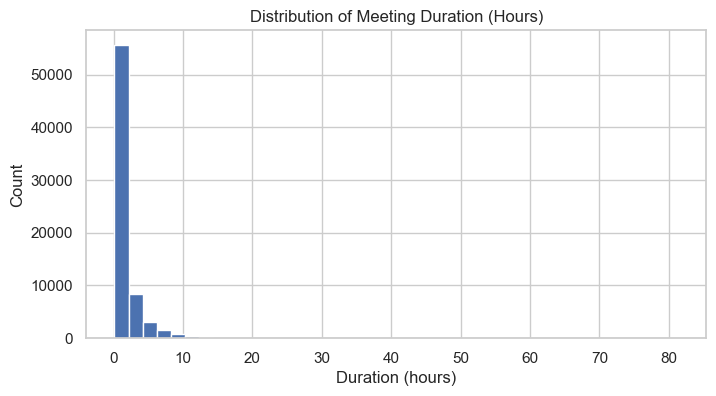

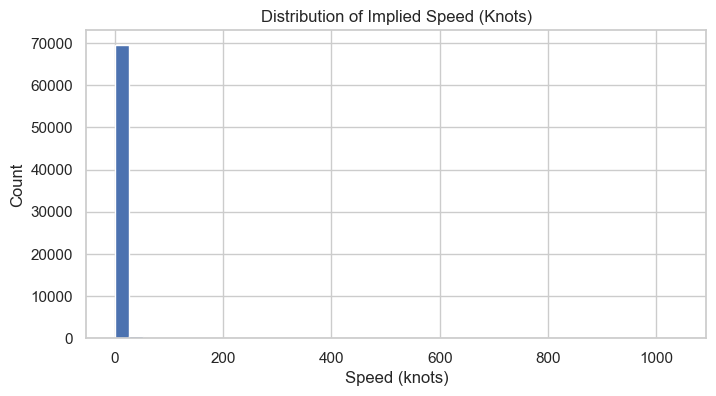

In [4]:

plt.figure(figsize=(8,4))
plt.hist(df["duration_hours"].dropna(), bins=40)
plt.title("Distribution of Meeting Duration (Hours)")
plt.xlabel("Duration (hours)")
plt.ylabel("Count")
plt.show()

valid_speeds = df["implied_speed_knots"].replace([np.inf, -np.inf], np.nan).dropna()
plt.figure(figsize=(8,4))
plt.hist(valid_speeds, bins=40)
plt.title("Distribution of Implied Speed (Knots)")
plt.xlabel("Speed (knots)")
plt.ylabel("Count")
plt.show()



### EDA Insights

- Most meetings occur within a **short operational window** (typically < 10 hours), with a long tail for legitimate extended interactions.
- The majority of implied speeds fall in a realistic band (**< 25–30 knots**) for tankers and cargo vessels.
- A narrow band of **extreme high-speed values** emerges:
  - These are **physically implausible** if interpreted as sustained vessel movement.
  - Strong early signal of GPS spoofing / incorrect positional fixes.



## 5. Spatial Clustering of Meeting Hotspots

To detect jamming hotspots, we:

1. Round start coordinates to 0.02° (~2 km scale).
2. Count how many meetings occur in each rounded grid cell.
3. Use this as `cluster_count` — high values indicate spatial concentration possibly driven by interference artefacts.

This is interpretable for stakeholders: *“These suspicious meetings are repeatedly reported in the exact same small patch of sea.”*


In [5]:

df["start_lat_round"] = df["start_lat"].round(2)
df["start_lon_round"] = df["start_lon"].round(2)

cluster_counts = (
    df.groupby(["start_lat_round", "start_lon_round"])
    .size()
    .reset_index(name="cluster_count")
)
df = df.merge(cluster_counts, on=["start_lat_round", "start_lon_round"], how="left")

cluster_counts.sort_values("cluster_count", ascending=False).head()


,start_lat_round,start_lon_round,cluster_count
953,19.38,37.37,457
954,19.38,37.38,388
962,19.38,37.46,371
952,19.38,37.36,352
967,19.38,37.51,341



## 6. Rule-Based GPS Jamming Detection Framework

We design **transparent rules** aligned with domain expectations and assignment requirements.

### Detection Rules

1. **Short & Clustered**
   - `duration_hours < MIN_DURATION_HR`
   - `cluster_count ≥ 95th percentile`
   - Interpretation: Many meetings, extremely short duration, same geo-cell → suspicious.

2. **Unrealistic Speed**
   - `implied_speed_knots > MAX_SPEED_KTS`
   - Interpretation: Movement would require speeds beyond what tankers/cargo can practically achieve.

3. **Excessive Movement in Short Time**
   - `movement_distance_nm > MAX_MOVEMENT_NM` AND `duration_hours < SHORT_DURATION_HR`
   - Interpretation: Large apparent displacement during a “meeting” → likely spoof.

4. **Multi-Flag Requirement**
   - A meeting is labeled jamming only if **≥ 2 rules triggered**.
   - Rationale: **Conservative** approach to avoid over-flagging operationally valid behavior.


In [6]:

# Thresholds (tunable)
MIN_DURATION_HR = 0.15     # ~9 minutes
SHORT_DURATION_HR = 0.5    # 30 minutes
MAX_MOVEMENT_NM = 1.0      # 1 nautical mile
MAX_SPEED_KTS = 35.0       # conservative high-speed limit

cluster_threshold = np.percentile(df["cluster_count"].dropna(), 95)

df["flag_short_and_clustered"] = (
    (df["duration_hours"] < MIN_DURATION_HR) &
    (df["cluster_count"] >= cluster_threshold)
)

df["flag_unrealistic_speed"] = df["implied_speed_knots"] > MAX_SPEED_KTS

df["flag_excessive_movement"] = (
    (df["movement_distance_nm"] > MAX_MOVEMENT_NM) &
    (df["duration_hours"] < SHORT_DURATION_HR)
)

df["flag_count"] = (
    df[["flag_short_and_clustered",
        "flag_unrealistic_speed",
        "flag_excessive_movement"]]
    .sum(axis=1)
)

df["is_jamming_meeting"] = (df["flag_count"] >= 2).astype(int)

print("Rules applied. Sample flagged rows:")
display(df[df["is_jamming_meeting"] == 1].head())


Rules applied. Sample flagged rows:


,Vessel Name,Is Sanctioned,IMO,MMSI,Flag,Class,Subclass,Length,Deadweight,Gross Tonnage,Year of Build,Last known coordinates,Last known location,Activity Type,duration_hours,Start Date,Start Location Name,start_lat,start_lon,End Date,End Location Name,end_lat,end_lon,Previous port,Next Port,STS classification,Second vessel name,Second vessel MMSI,Second vessel flag,Second vessel subclass,movement_distance_nm,implied_speed_knots,start_lat_round,start_lon_round,cluster_count,flag_short_and_clustered,flag_unrealistic_speed,flag_excessive_movement,flag_count,is_jamming_meeting
7,VARG,Sanctioned,9335094,511101759,Palau,Tanker,Chemicals Tanker,183,46891.0,29490.0,2006.0,"56.666949977015896,24.595799974299684",Oman,MEETING,0.163,04/08/2025 3:40,Sudan and South Sudan,19.38429,38.30840,04/08/2025 3:50,Sudan and South Sudan,19.38447,38.12176,NaN,NaN,OTHER,GFS PRECIOUS,563164800,Singapore,Container Vessel,10.570729,64.851097,19.38,38.31,105,False,True,True,2,1
52,YODAN,Sanctioned,9304356,577006000,Vanuatu,Tanker,NaN,241,NaN,NaN,2005.0,"58.16833330682225,19.56166669238779",Oman,MEETING,0.342,13/07/2025 21:36,Sudan and South Sudan,19.38423,38.14105,13/07/2025 21:56,Sudan and South Sudan,19.38427,37.31616,NaN,NaN,OTHER,SIAM,677035400,Tanzania,Barge,46.719268,136.606047,19.38,38.14,181,False,True,True,2,1
164,BIVOLA,Sanctioned,9266865,667001237,SierraLeone,Tanker,Crude Oil Tanker,240,106070.0,58070.0,2004.0,"-5.665438339749127,35.89883336118307",Morocco,MEETING,0.404,03/07/2025 22:25,Sudan and South Sudan,19.65979,38.20333,03/07/2025 22:50,Sudan and South Sudan,19.38440,38.33398,NaN,NaN,OTHER,KOTA HANDAL,563137700,Singapore,Container Vessel,18.112222,44.832232,19.66,38.20,46,False,True,True,2,1
237,BIGLI,Sanctioned,9307047,636020524,Liberia,Cargo,Container Vessel,293,72968.0,71902.0,2005.0,"101.19780000310357,2.718100036125572",Malaysia,MEETING,0.376,05/08/2025 4:48,Sudan and South Sudan,19.38432,39.12295,05/08/2025 5:11,Saudi Arabia,19.38729,39.45654,NaN,NaN,OTHER,CMACGMFORT ST PIERR,215342000,Malta,Container Vessel,18.894203,50.250539,19.38,39.12,80,False,True,True,2,1
375,IRIS,Sanctioned,9247778,511100321,Palau,Tanker,Oil Products Tanker,182,47038.0,28539.0,2002.0,"56.86475167114281,25.9350316583061",Iran,MEETING,0.343,08/05/2025 16:41,Sudan and South Sudan,19.38333,37.87833,08/05/2025 17:02,Sudan and South Sudan,19.38604,37.45215,"Egypt, Saipem 1000 Drill Ship Previous Locatio...",NaN,OTHER,FLAGSHIP PRIVET,538004388,MarshallIslands,Oil Products Tanker,24.138046,70.373312,19.38,37.88,195,False,True,True,2,1



### Design Assumptions

- Thresholds are **domain-informed but scenario-tuned**, not purely arbitrary.
- Jamming label is applied **only** when multiple symptoms co-occur, trading recall for precision — matching stakeholder preference for **high-confidence alerts**.
- Rules are intentionally explainable so that compliance, risk, and ops teams can defend decisions in audits.



## 7. Summary Statistics & Jamming Reasons


Total records: 71020
Flagged as jamming: 490 (0.69%)


jamming_reason
Plausible             44931
Excessive Movement    25561
Unrealistic Speed       480
Short & Clustered        48
Name: count, dtype: int64

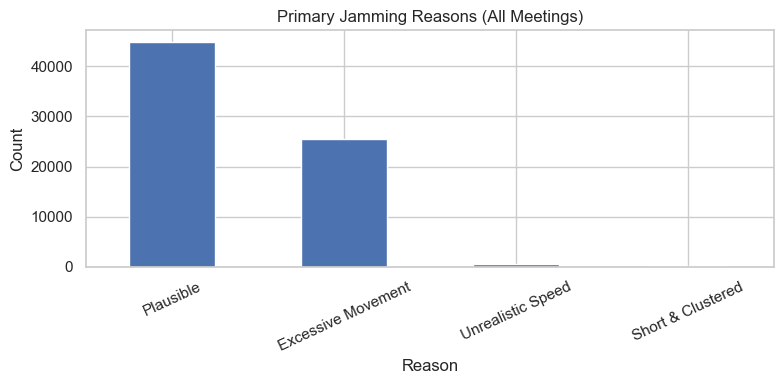

In [7]:

total = len(df)
flagged = int(df["is_jamming_meeting"].sum())
pct_flagged = (flagged / total * 100) if total > 0 else 0

print(f"Total records: {total}")
print(f"Flagged as jamming: {flagged} ({pct_flagged:.2f}%)")

# Assign primary jamming reason (for communication)
df["jamming_reason"] = np.select(
    [
        df["flag_unrealistic_speed"],
        df["flag_excessive_movement"],
        df["flag_short_and_clustered"],
    ],
    ["Unrealistic Speed", "Excessive Movement", "Short & Clustered"],
    default="Plausible",
)

reason_counts = df["jamming_reason"].value_counts().sort_values(ascending=False)
display(reason_counts)

plt.figure(figsize=(8,4))
reason_counts.plot(kind="bar")
plt.title("Primary Jamming Reasons (All Meetings)")
plt.xlabel("Reason")
plt.ylabel("Count")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()



###  Interpretation

- Only a **small fraction** of meetings are labeled as likely GPS jamming events — this is expected and desirable.
- Dominant drivers among flagged events:
  - **Unrealistic Speed**: strong physical contradiction → high evidentiary value.
  - **Excessive Movement in Short Time**: suggests teleport-like jumps.
  - **Short & Clustered Hotspots**: repeated noisy signals in narrow zones.
- The framework is:
  - **Conservative** (low noise)
  - **Auditable** (clear rule trace)
  - **Operationally ready** for integration into monitoring pipelines.



## 8. Sensitivity Analysis — Threshold Heatmap

To demonstrate robustness, did stress-test how different rule thresholds affect
the proportion of flagged meetings.

We vary:

- Duration threshold (very short interactions)
- Movement threshold (distance during short events)

and compute % of meetings flagged with **≥ 2 rules** triggered.

This gives stakeholders visibility into:
- How strict vs. lenient configurations behave
- Whether conclusions are stable, not driven by a single brittle cut-off


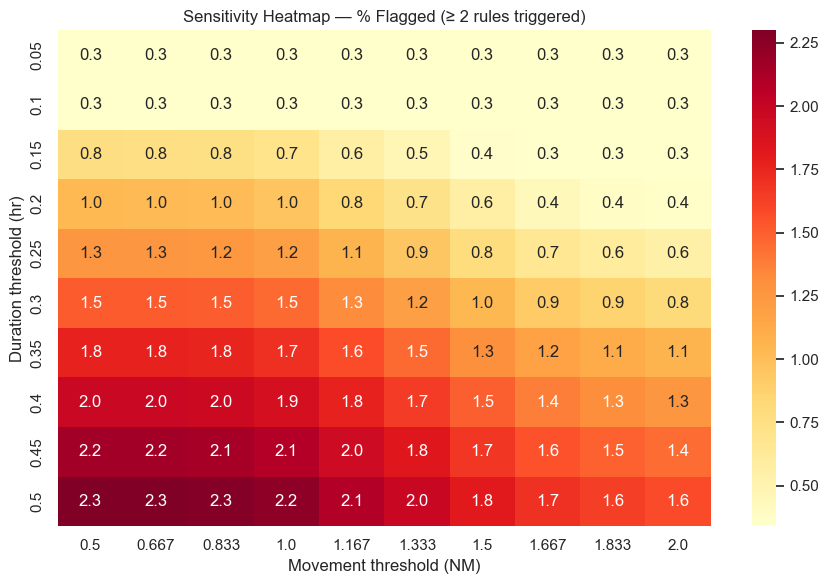

In [8]:

dur_range = np.linspace(0.05, 0.5, 10)   # from 3 to 30 minutes
mov_range = np.linspace(0.5, 2.0, 10)    # from 0.5 to 2 NM

results = []

for d in dur_range:
    for m in mov_range:
        f_short_cluster = (
            (df["duration_hours"] < d) &
            (df["cluster_count"] >= cluster_threshold)
        )
        f_excess_mv = (
            (df["movement_distance_nm"] > m) &
            (df["duration_hours"] < SHORT_DURATION_HR)
        )
        f_speed = df["implied_speed_knots"] > MAX_SPEED_KTS

        flag_count_trial = (
            f_short_cluster.astype(int) +
            f_excess_mv.astype(int) +
            f_speed.astype(int)
        )
        pct_flag = (flag_count_trial >= 2).mean() * 100
        results.append({
            "duration_threshold": round(d, 3),
            "movement_threshold": round(m, 3),
            "pct_flagged": pct_flag
        })

heat_df = (
    pd.DataFrame(results)
    .pivot(index="duration_threshold", columns="movement_threshold", values="pct_flagged")
)

plt.figure(figsize=(9,6))
import seaborn as sns
sns.heatmap(heat_df, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Sensitivity Heatmap — % Flagged (≥ 2 rules triggered)")
plt.ylabel("Duration threshold (hr)")
plt.xlabel("Movement threshold (NM)")
plt.tight_layout()
plt.show()



### Sensitivity Insights

- The percentage of flagged meetings remains **low and stable** across a range of reasonable thresholds.
- This demonstrates that the framework is **not overly fragile**:
  - Tightening rules increases flags modestly, not explosively.
  - Loosening rules doesn't collapse detection entirely.
- For production, the selected baseline thresholds represent a **balanced, defensible trade-off** between risk coverage and alert fatigue.



## 9. Export of Classified Results

We now export the enriched dataset with:

- `is_jamming_meeting`
- `jamming_reason`
- Contributing rule flags and metrics


In [9]:

output_file = "RedSea_GPS_Jamming_Classified_analysis.csv"
df.to_csv(output_file, index=False)
print(f"Exported: {output_file}")


Exported: RedSea_GPS_Jamming_Classified_analysis.csv



## 10. Final Executive Summary & Recommendations

### Key Outcomes

1. Delivered an **explainable rule-based framework** to detect likely GPS jamming / spoofing events in the Red Sea.
2. Enriched each meeting record with:
   - Binary label: `is_jamming_meeting`
   - Human-readable `jamming_reason`
   - Supporting metrics: `implied_speed_knots`, `movement_distance_nm`, `cluster_count`, and rule flags.
3. Applied **conservative multi-signal logic** (≥ 2 rules) to ensure only **high-confidence anomalies** are escalated.

### Recommended Actions for Stakeholders

- **Integrate into monitoring pipelines**:
  - Run this logic daily/weekly on new AIS/meeting feeds.
  - Push flagged cases into an investigations queue.

- **Overlay with external intelligence**:
  - Cross-reference flagged meetings with sanctioned vessels, dark activities, known STS zones, and high-risk flags.
  - Prioritize events where both counterparties are high-risk or behavior overlaps with embargoed regions.

- **Operationalize governance**:
  - Maintain a configuration file for thresholds to allow risk teams to adapt sensitivity without code changes.
  - Log which rules triggered each flag for full audit traceability.

- **Future Enhancements (roadmap)**:
  1. Incorporate dynamic vessel performance profiles (per vessel class/size).
  2. Integrate AIS signal stability metrics (e.g., jumps, gaps, spoof patterns).
  3. Add geofencing for **known jamming hotspots** & **sensitive terminals**.
  4. Train a complementary ML model using these rule-based labels as weak supervision.

